## Libraries

In [1]:
import rawpy as rw
import numpy as  np
%matplotlib inline
import matplotlib.pyplot as plt

## Reading the raw image

In [2]:
with rw.imread('Images/scene_raw.CR2.dng') as raw:
    CFA = raw.raw_image.copy()
    CFA_colors = raw.raw_colors.copy()
    color_desc = raw.color_desc
    white_level_per_channel = raw.camera_white_level_per_channel
    black_level_per_channel = raw.black_level_per_channel
    size = raw.sizes
    image = raw.postprocess()

In [3]:
color_desc

b'RGBG'

In [4]:
size

ImageSizes(raw_height=2622, raw_width=3948, height=2602, width=3906, top_margin=18, left_margin=42, iheight=2602, iwidth=3906, pixel_aspect=1.0, flip=0)

## Bayer Mask

In [5]:
def bayer_mask(CFA_colors, color_desc):
    
    R_mask = np.zeros_like(CFA_colors)
    G_mask = np.zeros_like(CFA_colors)
    B_mask = np.zeros_like(CFA_colors)
    
    RGB_mask = ({'R': np.zeros_like(CFA_colors), 
                 'B': np.zeros_like(CFA_colors), 
                 'G': np.zeros_like(CFA_colors)})
    
    n_channels = np.unique(CFA_colors)
    
    for n_channel, color in zip(n_channels, color_desc):
        
        mask = CFA_colors == n_channel
        
        RGB_mask[chr(color)][mask] = 1
        
    return RGB_mask

In [6]:
dict_bayer_mask = bayer_mask(CFA_colors, color_desc)

## Normalization

In [57]:
def remove_out_layers(image):
    
    mask = image < 0
    image[mask] = 0
    mask = image > 255
    image[mask] = 255
    
    return image

In [58]:
def normalization(CFA, dict_bayer_mask, white_level, black_level):
    
    CFA_norm = np.zeros_like(CFA)
    
    minimum_new = 0
    maximum_new = 255
    
    for key in dict_bayer_mask.keys():
        
        CFA_n = (CFA - black_level[key])*((maximum_new-minimum_new)/(white_level[key]-black_level[key])) + minimum_new
        
        CFA_filter = CFA_n*dict_bayer_mask[key]
        
        CFA_norm = CFA_norm + CFA_filter
    
    CFA_nomr = remove_out_layers(CFA_norm)
    
    return CFA_norm.astype(int)

In [59]:
CFA_norm = normalization(CFA,dict_bayer_mask,(
    {'R': 1000, 'G': 3000, 'B': 2000}),(
    {'R': 255, 'G': 255, 'B': 255}))

## Extract RGB

In [87]:
def extract_RGB(CFA, dict_bayer_mask):
    
    R = CFA*dict_bayer_mask['R']
    G = CFA*dict_bayer_mask['G']
    B = CFA*dict_bayer_mask['B']
    
    return R.astype(int), G.astype(int), B.astype(int)

def united(R, G, B):
    
    size = R.shape
    
    RGB = np.zeros((size[0], size[1], 3))
    
    RGB[:,:,0] = R.copy()
    RGB[:,:,1] = G.copy()
    RGB[:,:,2] = B.copy()
    
    return RGB.astype(int)

In [88]:
CFA_R, CFA_G, CFA_B = extract_RGB(CFA_norm, dict_bayer_mask)

CFA_RGB = united(CFA_R, CFA_G, CFA_B)

## Plotting Raw Data

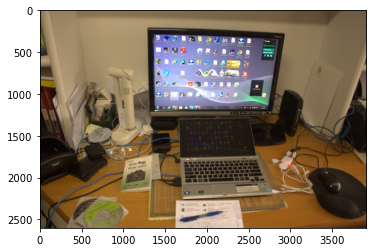

In [89]:
plt.imshow(image); # Image processing by RawPy

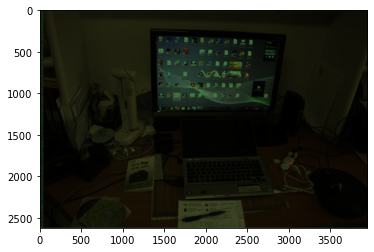

In [90]:
plt.imshow(CFA_RGB); # RGB image

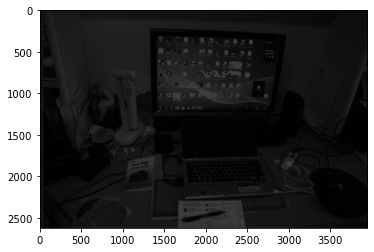

In [91]:
plt.imshow(CFA_R, cmap = 'gray'); # Red

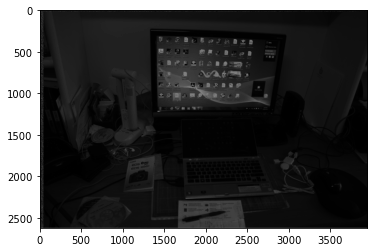

In [92]:
plt.imshow(CFA_G, cmap = 'gray'); # Green

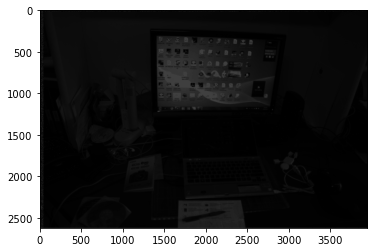

In [93]:
plt.imshow(CFA_B, cmap = 'gray'); # Blue

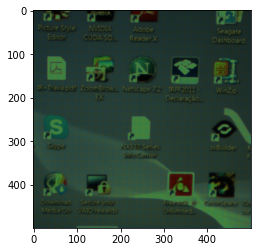

In [94]:
plt.imshow(CFA_RGB[500:1000,1500:2000,:]); ### RGB image

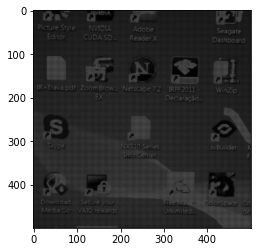

In [95]:
plt.imshow(CFA_R[500:1000,1500:2000], cmap = 'gray'); ### Red

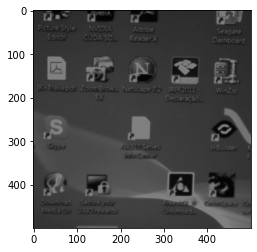

In [96]:
plt.imshow(CFA_G[500:1000,1500:2000], cmap = 'gray'); ### Green

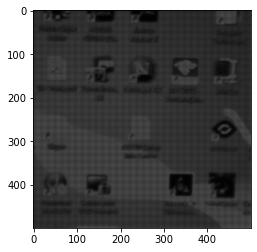

In [97]:
plt.imshow(CFA_B[500:1000,1500:2000], cmap = 'gray'); ### Blue

## Demosaicing

In [45]:
from scipy.ndimage.filters import convolve

In [98]:
def demosaicing_bayer_bilinear(CFA, dict_bayer_mask):
    
    G_filter = np.array([[0.0, 1.0, 0.0],
                     [1.0, 4.0, 1.0],
                     [0.0, 1.0, 0.0]])
    
    RB_filter = np.array([[1.0, 2.0, 1.0],
                          [2.0, 4.0, 2.0],
                          [1.0, 2.0, 1.0]])
    
    R = convolve(CFA[:,:,0] * dict_bayer_mask['R'], RB_filter)
    G = convolve(CFA[:,:,1] * dict_bayer_mask['G'], G_filter)
    B = convolve(CFA[:,:,2] * dict_bayer_mask['B'], RB_filter)
    
    R = remove_out_layers(R).astype(int)
    G = remove_out_layers(G).astype(int)
    B = remove_out_layers(B).astype(int)
    
    return R, G, B

In [99]:
R, G, B = demosaicing_bayer_bilinear(CFA_RGB, dict_bayer_mask)

In [100]:
image_demosaicing = united(R, G, B)

## Plotting image after demosaicing

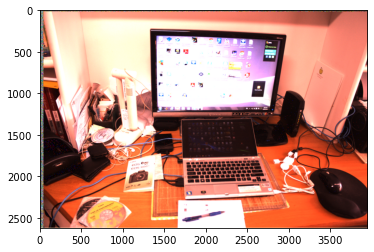

In [103]:
plt.imshow(image_demosaicing); # full image

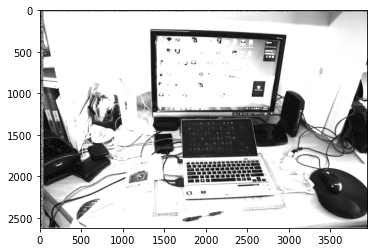

In [105]:
plt.imshow(R, cmap = 'gray'); # Red

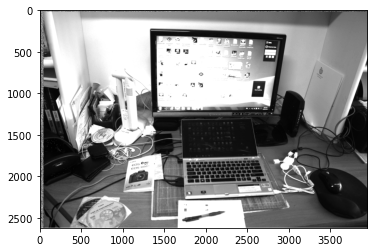

In [107]:
plt.imshow(G, cmap = 'gray'); # Green

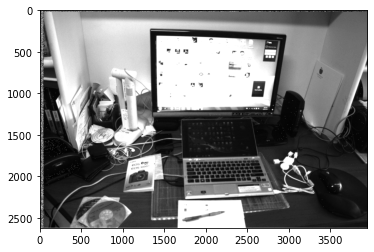

In [109]:
plt.imshow(B, cmap = 'gray'); # Blue

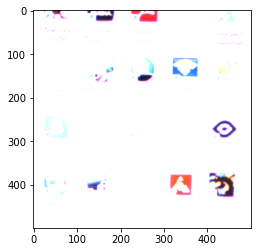

In [110]:
plt.imshow(image_demosaicing[500:1000,1500:2000,:]); ### RGB image

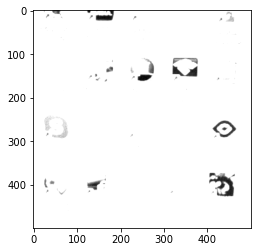

In [111]:
plt.imshow(R[500:1000,1500:2000], cmap = 'gray'); ### Red

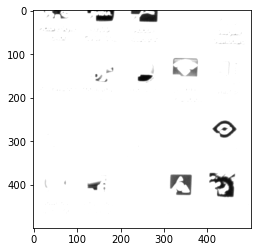

In [112]:
plt.imshow(G[500:1000,1500:2000], cmap = 'gray'); ### Green

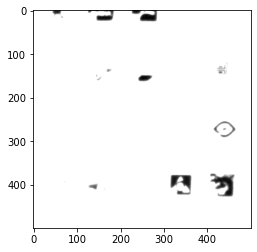

In [113]:
plt.imshow(B[500:1000,1500:2000], cmap = 'gray'); ### Blue

## White Balance